# Оценка кредитного риска
Мы работаем в банке. При получении зявки на кредит нам нужно убедиться, что в случае её одобрения клиент сможет его вернуть. Каждая заявка несет в себе риск дефолта - невозврата денег.

Мы хотели бы минимизировать этот риск: прежде чем соглашаться на предоставления кредита, стоит оценить клиента и вероятность дефолта. Если она слишком высока, то заявка будет отклонена. 

Для расчета этого риска вполне может быть использовано машинное обучение. Нам потребуется набор данных с кредитами, где для каждой заявки мы будем знать, был ли кредит успешно возвращен. Используя эти данные, мы построим модель для прогнозирования вероятности дефолта и сможем с ее помощью оценить риск того, что будущие заёмщики не вернут деньги.

План проекта состоит в следующем:
1. Сначала мы получим данные и выполним предварительную обработку.
2. Далее мы обучим модель дерева решений из Scikit-learn прогнощированию вероятности дефолта.
3. После этого мы настроим параметры дерева решений, чтобы достичь наилучшей производительности
4. Затем объединим несколько деревьев решений в одну модель - случайный лес.
5. Наконец мы исследуем другой способ объединения деревьев - градиентный бустинг. Мы используем XGBoost - высокоэффективную библиотеку, которая реализует градиентный бустинг. Мы обучим модель и настроим ее параметры.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost as xgb


%matplotlib inline

df = pd.read_csv('data.csv')

df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Переведем названия столбцов в нижний регистр

In [84]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Мы видим, что датафрейм содержит следующие столбцы:
- `status` — удалось ли клиенту погасить кредит (1) или нет (2);
- `seniority` — стаж работы в годах;
- `home` — тип домовладения: аренда (1), владение (2) и другие;
- `time` — планируемый срок предоставления кредита (в месяцах);
- `age` — возраст клиента;
- `marital [status]` — холост (1), женат (2) и др.;
- `records` — есть ли у клиента какие-либо предыдущие записи: нет (1), да (2)(из описания набора данных неясно, о каких записях здесь идет речь. Учитывая суть проекта‚ можно предположить, что речь о записях в базе данных банка);

- `job` — тип работы: полный рабочий день (1), неполный рабочий день (2) и другие;

- `expenses` — сколько клиент тратит в месяц;

- `income` — сколько клиент зарабатывает в месяц;

- `assets` — общая стоимость всех активов клиента;

- `debt` — сумма кредитной задолженности;

- `amount` — запрашиваемая сумма кредита;

- `price` — цена товара, который клиент хочет приобрести.

Хотя большинство столбцов числовые, мы видим и категориальные: status, home, marital [status], records и job. Однако значения, которые мы видим в датафрейме, являются числами. Это означает, что нам нужно привести их к их настоящим именам

Начнем со столбца `status`. 1  означает OK, 2 означает default, а 0 означает, что значение отсутствует - заменим его на unk (сокращение для unknown)

In [85]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

# Повтрим туже процедуру для остальных столбцов
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    7: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


Теперь посмотрим числовые столбцы. Сначала посмотрим сводную статистику методом describe

In [86]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


Сразу замечаем, что в некоторых случаях максимальное значение равно 99999999. Как оказалось, это искусственое значение - именно так кодируются недостающее значения в этом наборе данных

Эта проблема наблюдается в трех столбцах: income, assets и debt. Заменим это значение на NaN

In [87]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)
    
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Теперь у max совершенно другие значения. Посмотрим на нашу целевую переменную.

In [88]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

Всего одна строка со значением "unk". Для нашего проекта она бесполезна, поэтому сразу удалим ее из набора данных

In [89]:
df = df[df.status != 'unk']

### Подготовка набора данных

In [90]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

# Проверим размер наборов данных
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [91]:
# Раздели датасет на выборки
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

# Получим целевой признак
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

# Удалим целевую переменную из выборок
del df_train['status']
del df_val['status']

# Заполним пропуски нулями и преобразуем выборки в словари
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

# Создаем класс DicVectorizer для кодирования признаков
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

# Создадим класс решающего дерева и обучим модель
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Получим предсказания вероятностей
y_pred = dt.predict_proba(X_train)[:, 1]

# Получим AUC-метрику для тренировочного набора
roc_auc_score(y_train, y_pred)

1.0

Метрика показывает идеальный 100% результат. Проверим его на проверочной выборке.

In [92]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6556362161245791

Модель показывает 66% результат. Имеем случай переобучения - созданные решающим деревом правила слишком специфичны. Изменим глубину дерева

In [93]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

# Визуализируем полученное дерево
tree_text = export_text(dt, feature_names=dv.get_feature_names())
print(tree_text)

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



In [94]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


У нового дерева другая проблема - оно слишком простое. Чтобы улучшить ситуацию, нам необходимо настроить модель: попробуем разные парметры и посмотрим, какие из них приводят к наилучшему  AUC.

Начнем с параметра max_depth. Для этого мы переберем несколько разумных значений и попытаемся понять, как из них работает лучше всего:

In [95]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.757
  10 -> 0.680
  15 -> 0.664
  20 -> 0.649
None -> 0.663


Оптимальное значение глубины - 5 (76,7%), за ним следуют 4 (76,1%) и 6 (74,7%)

Далее настроим min_samples_leaf. Для этого переберем три наилучших параметра max_depth и для каждого используем разные значения min_samples_leaf:

In [96]:
for m in [4, 5, 6]:
    print('depth: %s' % m)
    
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
        
    print()   

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.767
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.753
5 -> 0.762
10 -> 0.778
15 -> 0.786
20 -> 0.774
50 -> 0.770
100 -> 0.776
200 -> 0.768



После запуска мы видим, что наилучший AUC составляет 78,5% с параметрами min_samples_leaf=15 и max_depth=6.

In [97]:
# Обучим окончательную модель
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15) 
dt.fit(X_train, y_train)
y_pred_dt = model.predict(dval)

## Обучение случайного леса

In [98]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('AUC:', auc)

AUC: 0.7848138819597491


Подберем параметр n_estimators

In [99]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    
    aucs.append(auc)

10 -> 0.785
20 -> 0.807
30 -> 0.813
40 -> 0.817
50 -> 0.819
60 -> 0.820
70 -> 0.823
80 -> 0.822
90 -> 0.824
100 -> 0.826
110 -> 0.824
120 -> 0.823
130 -> 0.822
140 -> 0.823
150 -> 0.823
160 -> 0.823
170 -> 0.824
180 -> 0.824
190 -> 0.824
200 -> 0.824


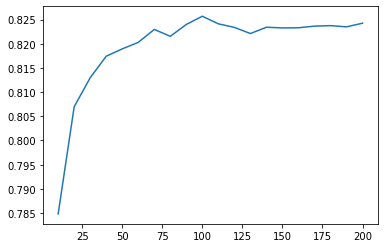

In [100]:
plt.plot(range(10, 201, 10), aucs)

Производительность быстро растет для первых 25-30 деревьев; затем рост замедляется. После 130 добавление большего количества деревьев больше не влияет на производительность, и она остается примерно на уровне 82%.

Протестируем несколько значений для max_depth и посмотрим, ка меняется AUC по мере роста количества деревьев

In [101]:
all_aucs = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []
    
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth,
                                   random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.793
20 -> 0.796
30 -> 0.798
40 -> 0.801
50 -> 0.802
60 -> 0.803
70 -> 0.806
80 -> 0.806
90 -> 0.806
100 -> 0.806
110 -> 0.807
120 -> 0.807
130 -> 0.808
140 -> 0.808
150 -> 0.808
160 -> 0.808
170 -> 0.808
180 -> 0.808
190 -> 0.808
200 -> 0.808

depth: 10
10 -> 0.810
20 -> 0.821
30 -> 0.823
40 -> 0.824
50 -> 0.821
60 -> 0.823
70 -> 0.823
80 -> 0.824
90 -> 0.825
100 -> 0.826
110 -> 0.827
120 -> 0.827
130 -> 0.826
140 -> 0.826
150 -> 0.826
160 -> 0.827
170 -> 0.826
180 -> 0.826
190 -> 0.826
200 -> 0.826

depth: 20
10 -> 0.774
20 -> 0.795
30 -> 0.799
40 -> 0.808
50 -> 0.811
60 -> 0.815
70 -> 0.816
80 -> 0.818
90 -> 0.821
100 -> 0.822
110 -> 0.823
120 -> 0.823
130 -> 0.822
140 -> 0.822
150 -> 0.824
160 -> 0.825
170 -> 0.826
180 -> 0.825
190 -> 0.825
200 -> 0.825



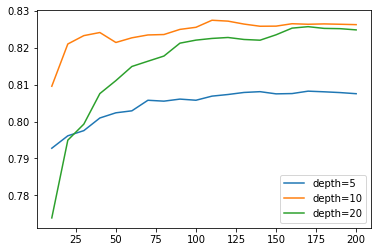

In [102]:
num_trees = list(range(10, 201,10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

При max_depth=10 AUC превышает 82%, тогда как при других значениях показатель работает хуже

Теперь настроим min_samples_leaf

In [103]:
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10,
                                   min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
        
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.809
30 -> 0.820
50 -> 0.820
70 -> 0.822
90 -> 0.823
110 -> 0.824
130 -> 0.825
150 -> 0.826
170 -> 0.826
190 -> 0.827

min_samples_leaf: 5
10 -> 0.806
30 -> 0.818
50 -> 0.820
70 -> 0.819
90 -> 0.819
110 -> 0.820
130 -> 0.822
150 -> 0.822
170 -> 0.822
190 -> 0.822

min_samples_leaf: 10
10 -> 0.802
30 -> 0.819
50 -> 0.820
70 -> 0.821
90 -> 0.821
110 -> 0.821
130 -> 0.823
150 -> 0.822
170 -> 0.822
190 -> 0.822



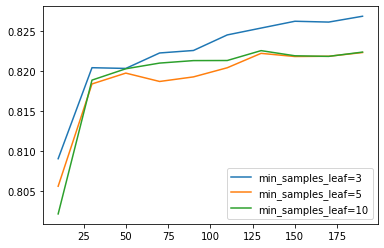

In [104]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

AUC выглядит немного лучше для небольших значений min_samples_leaf, а наилучшее значение равно 3

Таким образом, наилучшими параметрами для случайного леса для нашей задачи являются:
- max_depth=10
- min_samples_leaf=3
- n_estimators=190


In [107]:
# Обучим окончательную модель
rf = RandomForestClassifier(n_estimators=190, max_depth=10,
                           min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.8222887554188564

## Градиентный бустинг

Случайный лес не единственный способ объединить несколько моделей в одном ансамбле. В качестве альтернативы мы можем обучать модели последовательно - каждая следующая модель пытается испроавить ошибки предыдущей. Такой способ объединения называется бустингом. Градиентный бустинг - особая разновидность этого подхода, которая особенно хорошо работает с деревьями.

В этом проекте для градиентного бустинга мы будем использовать XGBoost. Однако прежде чем обучить модель, нам нужно обернуть наши данные в DMatrix - специальная структура данных для эффективного поиска разбиений

In [108]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

Следующий шаг - указание параметров для обучения

In [109]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
}

Для обучения модели XGBoost мы используем функцию `train`. Начнем с десяти деревьев.

In [110]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [111]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.07751459, 0.07131889, 0.0675393 , 0.12096145, 0.05379206,
       0.06382526, 0.06665564, 0.4352498 , 0.41923273, 0.02550563],
      dtype=float32)

In [112]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

В результате мы получаем 81,4.  овольно хороший итог, но он все еще хуже, чем наша лучшая модель случайного леса (82,5%)

Чтобы получить представление о том,  как меняется AUC по мере роста количества деревьев, мы можем использовать список наблюдений - встроенную в XGBoost функцию мониторинга производительности модели.

In [113]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Также немного изменим список параметров, добавив используемую метрику AUC
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

In [114]:
# Обучим модель
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86730	val-auc:0.77938
[10]	train-auc:0.95447	val-auc:0.80851
[20]	train-auc:0.97464	val-auc:0.81729
[30]	train-auc:0.98579	val-auc:0.81543
[40]	train-auc:0.99421	val-auc:0.80922
[50]	train-auc:0.99653	val-auc:0.80918
[60]	train-auc:0.99817	val-auc:0.81172
[70]	train-auc:0.99934	val-auc:0.80870
[80]	train-auc:0.99979	val-auc:0.80549
[90]	train-auc:0.99993	val-auc:0.80409
[99]	train-auc:0.99999	val-auc:0.80560


In [115]:
%%capture output

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=5)

In [116]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

Теперь построим график 

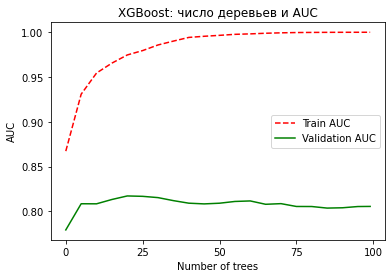

In [117]:
tree, aucs_train, aucs_val = parse_xgb_output(output)

plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='red', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='green', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: число деревьев и AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_xgb_default.svg')

plt.show()

### Настройка параметров: eta
Сначала мы попрбуем настроить параметр eta

In [118]:

%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [119]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.81729
(0.81729, 20)


In [120]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [121]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.82781
(0.82781, 60)


In [122]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [123]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.82819
(0.82819, 110)


In [124]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [125]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.82635
(0.82635, 499)


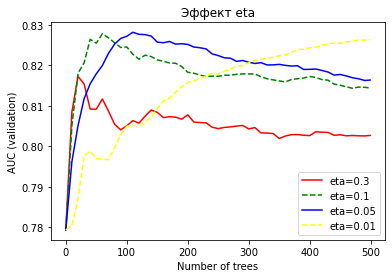

In [126]:

plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='red', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='green', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='blue', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='yellow', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('Эффект eta')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

### Настройка параментров: max_depth
Сначала попробуем 3

In [127]:

%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [128]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.8317
(0.8317, 110)


Теперь попробуем 10

In [129]:

%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [130]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.81729
(0.81458, 130)


С глубиной 3 лучше чем с глубиной 10. Попробуем с глубиной 4

In [131]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [132]:
tree, _, aucs_val_depth4 = parse_xgb_output(output)
print(max(aucs_val_depth4))
print(max(zip(aucs_val_depth4, tree)))

0.82952
(0.82952, 90)


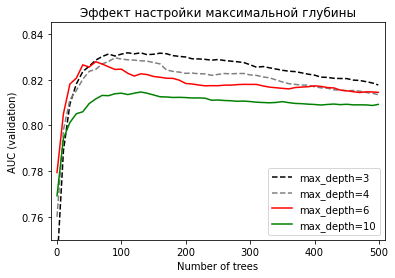

In [133]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, color='black', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth4, color='grey', linestyle='dashed', label='max_depth=4')
plt.plot(tree, aucs_val_eta_01, color='red', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='green', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.845)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('Эффект настройки максимальной глубины')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_depth.svg')

plt.show()

Получилось не лучше, поэтому оставляем 3

## Настройка параметра min_child_weight
Cначала попробуем значение по умолчанию

In [134]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [135]:

tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.8317
(0.8317, 110)


In [136]:

%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [137]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.83515
(0.83515, 160)


In [138]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [139]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.83743
(0.83743, 160)


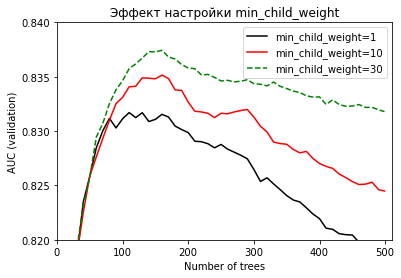

In [140]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, color='red', linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, color='green', linestyle='dashed', label='min_child_weight=30')

plt.ylim(0.82, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.82, 0.84, 5))

plt.legend()

plt.title('Эффект настройки min_child_weight')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')


plt.show()

### Проверка лучшего кол-ва деревьев

In [141]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [142]:
print(output)

[0]	train-auc:0.77610	val-auc:0.73891
[10]	train-auc:0.84675	val-auc:0.78896
[20]	train-auc:0.86931	val-auc:0.80928
[30]	train-auc:0.88080	val-auc:0.81808
[40]	train-auc:0.89038	val-auc:0.82347
[50]	train-auc:0.89756	val-auc:0.82583
[60]	train-auc:0.90319	val-auc:0.82847
[70]	train-auc:0.90768	val-auc:0.83005
[80]	train-auc:0.91221	val-auc:0.83117
[90]	train-auc:0.91638	val-auc:0.83029
[100]	train-auc:0.91913	val-auc:0.83113
[110]	train-auc:0.92297	val-auc:0.83170
[120]	train-auc:0.92544	val-auc:0.83124
[130]	train-auc:0.92789	val-auc:0.83169
[140]	train-auc:0.92996	val-auc:0.83088
[150]	train-auc:0.93200	val-auc:0.83108
[160]	train-auc:0.93416	val-auc:0.83154
[170]	train-auc:0.93638	val-auc:0.83129
[180]	train-auc:0.93842	val-auc:0.83046
[190]	train-auc:0.94005	val-auc:0.83014
[200]	train-auc:0.94181	val-auc:0.82986
[210]	train-auc:0.94374	val-auc:0.82907
[220]	train-auc:0.94529	val-auc:0.82902
[230]	train-auc:0.94725	val-auc:0.82884
[240]	train-auc:0.94840	val-auc:0.82846
[250]	train

In [143]:
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.8317


In [144]:

max(zip(aucs_val, tree))

(0.8317, 110)

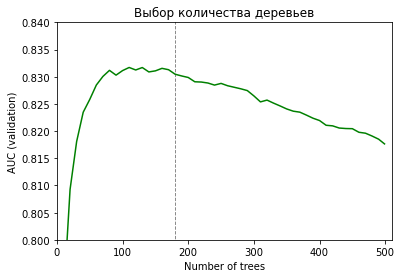

In [145]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='green', linestyle='solid')


plt.ylim(0.80, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.84, 9))


plt.vlines(180, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Выбор количества деревьев')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_number_trees.svg')

plt.show()

Финальная модель

In [146]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=180, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.77610	val-auc:0.73891
[10]	train-auc:0.84675	val-auc:0.78896
[20]	train-auc:0.86931	val-auc:0.80928
[30]	train-auc:0.88080	val-auc:0.81808
[40]	train-auc:0.89038	val-auc:0.82347
[50]	train-auc:0.89756	val-auc:0.82583
[60]	train-auc:0.90319	val-auc:0.82847
[70]	train-auc:0.90768	val-auc:0.83005
[80]	train-auc:0.91221	val-auc:0.83117
[90]	train-auc:0.91638	val-auc:0.83029
[100]	train-auc:0.91913	val-auc:0.83113
[110]	train-auc:0.92297	val-auc:0.83170
[120]	train-auc:0.92544	val-auc:0.83124
[130]	train-auc:0.92789	val-auc:0.83169
[140]	train-auc:0.92996	val-auc:0.83088
[150]	train-auc:0.93200	val-auc:0.83108
[160]	train-auc:0.93416	val-auc:0.83154
[170]	train-auc:0.93638	val-auc:0.83129
[179]	train-auc:0.93839	val-auc:0.83048


In [147]:
y_pred_xgb = model.predict(dval)

In [148]:
roc_auc_score(y_val, y_pred_xgb)

0.8304806132086897

In [149]:
print(roc_auc_score(y_val, y_pred_dt))
print(roc_auc_score(y_val, y_pred_rf))
print(roc_auc_score(y_val, y_pred_xgb))

0.8304806132086897
0.8222887554188564
0.8304806132086897


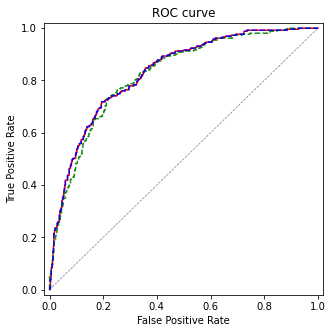

In [154]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_xgb)
plt.plot(fpr, tpr, color='red')

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='green', linestyle='dashed', alpha=0.9)

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='blue', linestyle='dashed', alpha=0.9)

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

## Финальный тест

In [155]:
y_train_full = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

del df_train_full['status']
del df_test['status']

In [156]:
dict_train_full = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dict_train_full)
X_test = dv.transform(dict_test)

In [157]:
rf_final = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf_final.fit(X_train_full, y_train_full)

y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [158]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

In [159]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

num_trees = 160

xgb_final = xgb.train(xgb_params, dtrain_full, num_boost_round=num_trees)

In [160]:
y_pred_xgb = xgb_final.predict(dtest)

In [161]:
print(roc_auc_score(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_xgb))

0.824269341674405
0.833634719710669


## Важность признаков

### Дерево решений

In [162]:
dt.feature_importances_

array([0.01387723, 0.04793733, 0.1226385 , 0.00833288, 0.0250906 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18724799, 0.00699145, 0.        ,
       0.        , 0.17292753, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0302163 ,
       0.        , 0.24421676, 0.12658146, 0.01394197])

In [163]:
list(zip(dv.feature_names_, dt.feature_importances_))

[('age', 0.013877231876069153),
 ('amount', 0.04793733336664824),
 ('assets', 0.12263850423922844),
 ('debt', 0.008332876385504902),
 ('expenses', 0.025090602575881322),
 ('home', 0.0),
 ('home=ignore', 0.0),
 ('home=other', 0.0),
 ('home=owner', 0.0),
 ('home=parents', 0.0),
 ('home=private', 0.0),
 ('home=rent', 0.0),
 ('income', 0.18724798934476602),
 ('job=fixed', 0.006991445659436667),
 ('job=freelance', 0.0),
 ('job=others', 0.0),
 ('job=parttime', 0.17292752964348085),
 ('job=unk', 0.0),
 ('marital=divorced', 0.0),
 ('marital=married', 0.0),
 ('marital=separated', 0.0),
 ('marital=single', 0.0),
 ('marital=unk', 0.0),
 ('marital=widow', 0.0),
 ('price', 0.030216298419676543),
 ('records=no', 0.0),
 ('records=yes', 0.24421675762093445),
 ('seniority', 0.12658145602795504),
 ('time', 0.013941974840418331)]

In [164]:
importances = list(zip(dv.feature_names_, dt.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
26,records=yes,0.244217
12,income,0.187248
16,job=parttime,0.172928
27,seniority,0.126581
2,assets,0.122639
1,amount,0.047937
24,price,0.030216
4,expenses,0.025091
28,time,0.013942
0,age,0.013877


In [165]:
df_importance = df_importance[df_importance.gain > 0]

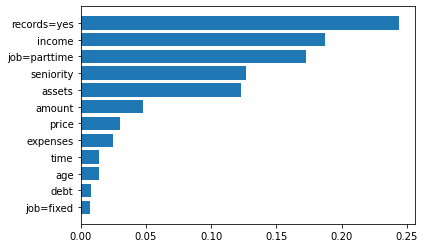

In [166]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

### Случайный лес

In [171]:
rf.feature_importances_

array([5.60330430e-02, 8.08339238e-02, 7.97208678e-02, 1.46145766e-02,
       3.76882811e-02, 0.00000000e+00, 1.42009599e-05, 4.96881734e-03,
       2.39340239e-02, 9.52267770e-03, 3.13679747e-03, 1.43428605e-02,
       1.49208077e-01, 4.56602949e-02, 1.02393085e-02, 2.27659690e-03,
       6.31958674e-02, 0.00000000e+00, 2.96297237e-04, 7.39949382e-03,
       7.94771682e-04, 6.42314474e-03, 0.00000000e+00, 6.66406093e-05,
       6.75299107e-02, 8.49670300e-02, 8.25923271e-02, 1.23731110e-01,
       3.08090588e-02])

In [172]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
12,income,0.149208
27,seniority,0.123731
25,records=no,0.084967
26,records=yes,0.082592
1,amount,0.080834
2,assets,0.079721
24,price,0.067530
16,job=parttime,0.063196
0,age,0.056033
13,job=fixed,0.045660


In [173]:
df_importance = df_importance[df_importance.gain > 0.01]

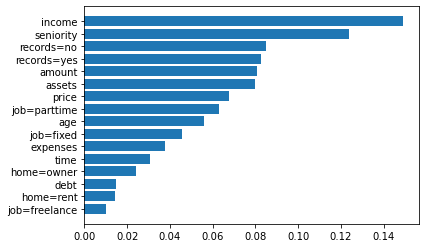

In [174]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

### XGBoost

In [175]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('records=no', 22.24321746826172),
 ('job=fixed', 21.592741012573242),
 ('job=parttime', 16.440664291381836),
 ('seniority', 11.689960479736328),
 ('income', 8.1557035446167),
 ('home=owner', 6.669165134429932),
 ('assets', 6.5446906089782715),
 ('amount', 5.51829719543457),
 ('home=parents', 5.010105133056641),
 ('home=rent', 4.2977776527404785),
 ('time', 4.0505523681640625),
 ('price', 3.603771686553955),
 ('expenses', 3.6012556552886963),
 ('age', 3.2517170906066895),
 ('marital=married', 2.872762441635132),
 ('home=private', 2.719832181930542),
 ('marital=separated', 2.450335741043091),
 ('debt', 2.4464755058288574),
 ('job=others', 2.156588315963745),
 ('home=other', 2.070114850997925),
 ('job=freelance', 2.017198085784912),
 ('marital=divorced', 0.7956474423408508),
 ('home=ignore', 0.7399988174438477)]

In [176]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('price', 174.0),
 ('amount', 157.0),
 ('income', 141.0),
 ('assets', 125.0),
 ('age', 123.0),
 ('seniority', 118.0),
 ('expenses', 86.0),
 ('records=no', 57.0),
 ('debt', 54.0),
 ('time', 35.0),
 ('job=parttime', 23.0),
 ('home=parents', 19.0),
 ('marital=separated', 15.0),
 ('job=fixed', 14.0),
 ('home=rent', 12.0),
 ('home=private', 12.0),
 ('home=owner', 11.0),
 ('marital=married', 9.0),
 ('home=other', 6.0),
 ('home=ignore', 4.0),
 ('job=freelance', 3.0),
 ('marital=divorced', 2.0),
 ('job=others', 2.0)]

In [177]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

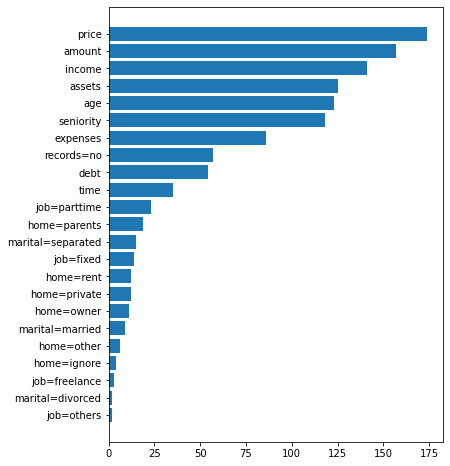

In [178]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

## Заключение
При проведении вышеизложенного исследования были обучены и проверены три модели машинного обучения: дерево решений, случайный лес и XGBoost. Наибольшую эффективность и лучшую обощающую способность показали случайный лес и XGBoost, с оценкой Roc_auc_score 82% и 83% соответственно.

Исследование важности признаков показало, что при классификации самыми важными параметрами оказались уровень дохода клиента и величина самого кредита. Чем  выше уровень дохода, тем больше вероятность, что клиент вернет кредит. С суммой кредита верно обратное - чем она больше, тем выше риск невозврата. 